# Using SBI to infer parameter given observed data

Once simulated data has been generated (see `1_simulation` notebook), applying SBI is straight forward using the `sbi` package: 

- select an SBI method, we use SNPE (see paper for details)
- add the simulated data and corresponding parameters to the SNPE object
- call `train()` to start the training of the underlying neural networks
- obtain the posterior, DONE. 

In [10]:
import pickle

from sbi.analysis import pairplot
from sbi.inference import SNPE
from sbi.utils import posterior_nn

from consbi import DATA_PATH, RESULTS_PATH, BASE_PATH

In [11]:
# Load data
with open(DATA_PATH.joinpath("presimulated_dso_gaussian_05_n500000.p"), "rb") as fh:
    prior, theta, x = pickle.load(fh).values()

In [17]:
# Set up inference
trainer = SNPE(
    prior,
    # we pass NSF to specify to type of neural network used to learn the posterior approximation. 
    # NSF = neural spline flow (Durkan et al. 2019).
    density_estimator="nsf",
)

# add training data to trainer.
num_training_data = 10000
trainer.append_simulations(theta[:num_training_data], x[:num_training_data]);

In [18]:
# train
posterior_estimator = trainer.train()

 Neural network successfully converged after 84 epochs.

In [19]:
# obtain posterior
posterior = trainer.build_posterior()

/home/janfb/anaconda3/envs/spp/lib/python3.7/site-packages/nflows/transforms/lu.py:81: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at /opt/conda/conda-bld/pytorch_1666643004612/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:2115.)
  outputs.t(), lower, upper=False, unitriangular=True


(<Figure size 720x720 with 9 Axes>,
 array([[<AxesSubplot:xlabel='dim 1'>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:xlabel='dim 2'>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:xlabel='dim 3'>]],
       dtype=object))

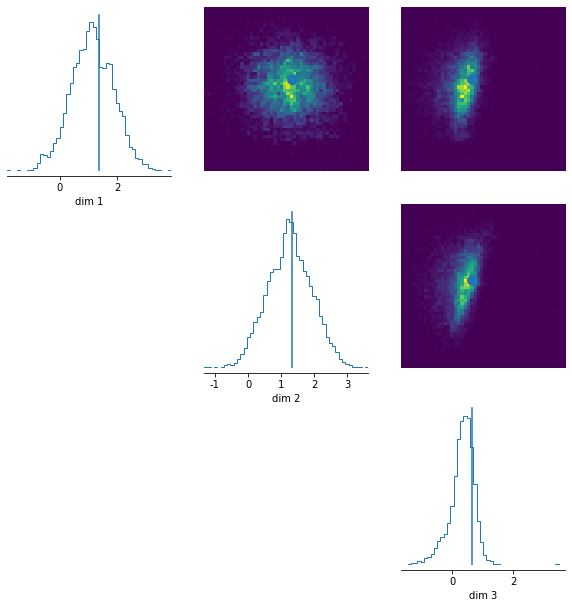

In [20]:
# we trained on simulated data. 
# To perform inference we would normally pass the actually observed data to the posterior object.
# Here, for demonstration we simpy pass the first object in the training data set as observed data.
x_o = x[:1]

# Consequently, we actually know the underlying ground truth parameters used to generate this data.
# In the plot below we will see how the posterior nicely clusters around this parameter value.
theta_o = theta[:1]

# pass x_o and generate samples
samples = posterior.sample((10000,), x=x_o)
# plot as pairplot.
pairplot(samples, points=theta[:1], );

Lastly, we save the inference object for analysis. See `3_posterior_analysis` for more.

In [22]:
# save posterior for analysis
with open(RESULTS_PATH.joinpath(f"tutorial_posterior_gaussian_05_N{num_training_data}.p"), "wb") as fh: 
    pickle.dump(dict(prior=prior, 
                     posterior=posterior, 
                     theta=theta,
                     x=x, 
                    ),
                fh,
               )